# BraTS Challenge Demo-Notebook

<a href="https://colab.research.google.com/github/Space-Dream-42/brainTumourProject/blob/main/Code/demo.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import gc

from dataset_utils import split_cube
from visualization_utils import plot_confusion_matrix, plot_loss, animate_cube, get_positives_negatives_from_cm
from data_loading import get_train_test_iters
torch.manual_seed(42)
from Architectures.unet_3d import UNet3D
from Architectures.unet_3d_context import UNet3D_Mini
from Architectures.unet_2d import UNet2D
from train import train_model
from custom_losses import DiceLoss, FocalTverskyLoss

#### Set Device

In [2]:
# set device (hopefully to gpu) and clean cache
use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')
print(f'Using {device} for training.')
gc.collect()
if use_gpu:
    torch.cuda.empty_cache()

Using cuda for training.


#### Load our Dataset

In [3]:
batch_size = 25
dataset_path = os.path.join('..', 'Task01_BrainTumour', 'cropped')
train_iter, test_iter = get_train_test_iters(dataset_path, batch_size=batch_size, shuffle=True, num_workers=0)

#### Set Hyperparameters, Model, Optimizer and Loss-Function 

In [4]:
# hyperparameters
train_3d = True
add_context = False # model with added context is memory-intensive!
compute_test_loss = True
epochs = 10
learning_rate = 1e-2

# init model
if train_3d:
    if add_context:
        model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    model = UNet2D().to(device)

# init optimizer and loss_fn
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = DiceLoss()

#### Train the Model

In [5]:
print(f'training {model.__class__.__name__}:')
train_losses, test_losses = train_model(model, optim, loss_fn, epochs, device, dataset_path, 
                                        batch_size, train_3d, add_context, compute_test_loss)

training UNet3D:
epoch 0: epoch_train_loss=0.770, epoch_test_loss=0.740
epoch 1: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 2: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 3: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 4: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 5: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 6: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 7: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 8: epoch_train_loss=0.740, epoch_test_loss=0.740
epoch 9: epoch_train_loss=0.740, epoch_test_loss=0.740


#### Plot Training- (and optionally Test) Losses

Loss curve using DiceLoss():


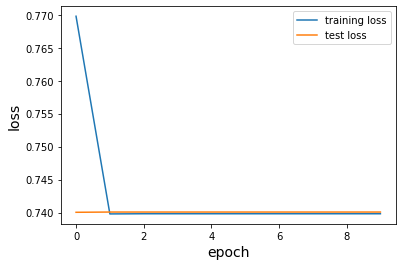

In [6]:
print(f'Loss curve using {loss_fn}:')
plot_loss(train_losses, test_losses)

#### Load a trained Model for Inference

In [7]:
# Set the path to 'Weights' dir with trained model weights (see file-structure in README)
weights_path = os.path.join('..','Weights')
weights_filename = os.listdir(weights_path)[len(os.listdir(weights_path))-1]

# Create an instance of the trained model for inference
if train_3d:
    if add_context:
        inference_model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        inference_model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    inference_model = UNet2D().to(device)

# Load the weights
inference_model.load_state_dict(torch.load(os.path.join(weights_path, weights_filename)))
inference_model.eval();

#### Animated prediction

<IPython.core.display.Javascript object>


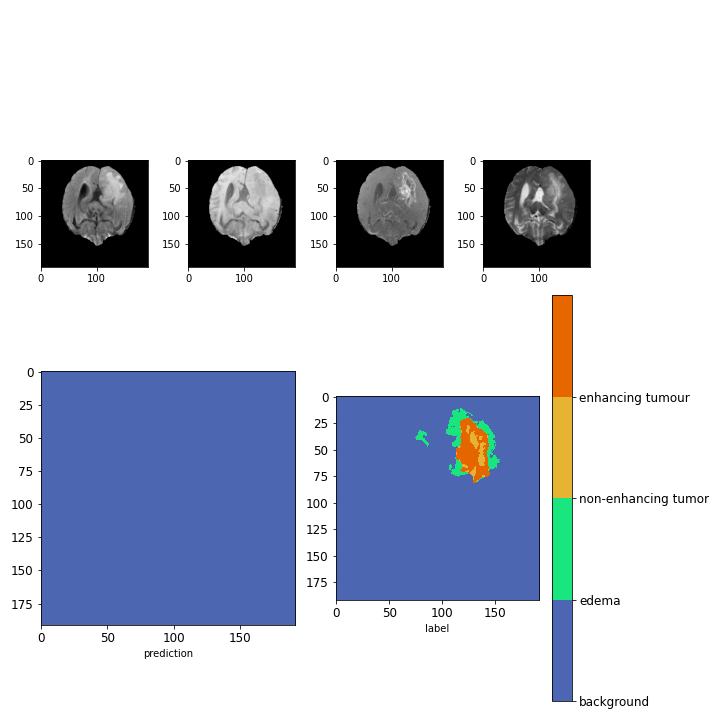

In [8]:
# Get a sample batch
train_iter, test_iter = get_train_test_iters(dataset_path, batch_size=batch_size, 
                                             shuffle=False, num_workers=0)
batch = test_iter.next()

# Create the animation
%matplotlib notebook
ani = animate_cube(inference_model, batch, add_context, device, train_3d)
plt.show()
del batch, train_iter, test_iter

#### Confusion Matrix and Metrics

Creating confusion matrix...


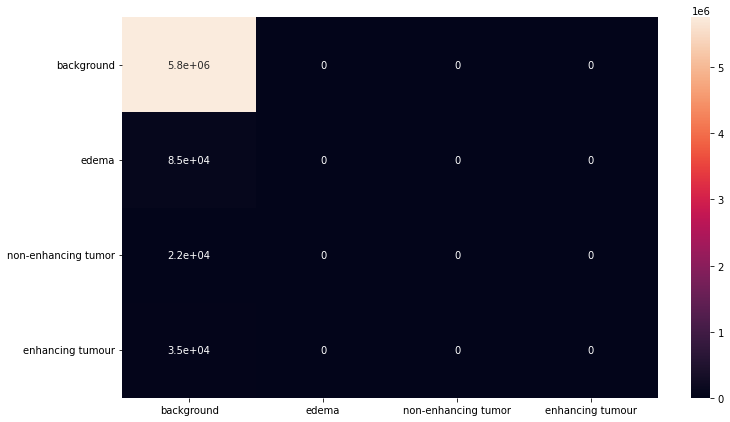

In [9]:
gc.collect()
# Create new data iterators
%matplotlib inline
train_iter, test_iter = get_train_test_iters(os.path.join('..', 'Task01_BrainTumour', 'cropped'),
                                             batch_size=batch_size, shuffle=False, num_workers=0)
del train_iter
# Create the confusion matrix (for the test dataset)
cf_matrix_visu, cf_matrix = plot_confusion_matrix(test_iter, model, train_3d, 
                                                  add_context, device=device)
cf_matrix_visu.show()

In [10]:
# Show different metrics (for the test dataset)
get_positives_negatives_from_cm(cf_matrix.to_numpy())

background:
tp: 5756146
fp: 0
tn: 0
fn: 142094
precision: 1.000
recall: 0.976
accuracy: 0.976
f1_score: 0.988

edema:
tp: 0
fp: 84584
tn: 5813656
fn: 0
precision: 0.000
recall: nan
accuracy: 0.000
f1_score: nan

non-enhancing tumor:
tp: 0
fp: 22321
tn: 5875919
fn: 0
precision: 0.000
recall: nan
accuracy: 0.000
f1_score: nan

enhancing tumour:
tp: 0
fp: 35189
tn: 5863051
fn: 0
precision: 0.000
recall: nan
accuracy: 0.000
f1_score: nan



/home/till/Desktop/GitHub/brainTumourProject/Code/visualization_utils.py:224: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp[i]/(tp[i]+fn[i])
